<a href="https://colab.research.google.com/github/serereuk-tf/Unsupervised-Learning/blob/main/Day3/flow_Example1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import tensorflow_probability as tfp
import tensorflow as tf
from tensorflow.keras import Input, Model
from tqdm import trange

In [43]:
@tf.function
def inverse_sigmoid(x):
   return -tf.math.log(tf.math.reciprocal(x) - 1.)

@tf.function
def bpd(z, dzdx):
    return -tf.reduce_mean(tfp.distributions.Normal(0., 1.).log_prob(z)+ tf.math.log(dzdx)) / np.log(2)

def sample_data(count):
   a = -1 + 0.2 * np.random.randn(count)
   b = 0.5 + 0.5 * np.random.randn(count)
   mask = np.random.rand(count) < 0.5
   return (a * mask + b * (1 - mask))[:, None]

def data_pdf(xs):
   return 0.5 * scipy.stats.norm.pdf(xs, -1, 0.2) + 0.5 * scipy.stats.norm.pdf(xs, 0.5, 0.5)

In [44]:
class flow(tf.keras.layers.Layer):
    def __init__(self, hdim=128):
        super(flow, self).__init__()
        mu_init = tf.random_normal_initializer(0., 0.01)
        logscale_init = tf.random_normal_initializer(0., 0.01)
        logits_init = tf.random_normal_initializer(0., 0.01)

        self.mu = tf.Variable(
            initial_value=mu_init(shape=(1, hdim)),trainable=True)
        
        self.logscale = tf.Variable(initial_value=logscale_init(
            shape=(1, hdim)), trainable=True)
        
        self.logits = tf.Variable(initial_value=logits_init(
            shape=(1, hdim),), trainable=True)
        

    def call(self, inputs):
        with tf.GradientTape() as tape:
            tape.watch(inputs)
            weights = tf.nn.softmax(self.logits, axis=1)
            scale = tf.exp(self.logscale)
            mu = tf.tile(self.mu, [tf.keras.backend.shape(inputs)[0], 1])
            scale = tf.tile(scale, [tf.keras.backend.shape(inputs)[0], 1])
            cdfs = tfp.distributions.Normal(mu, scale).cdf(inputs)
            z = inverse_sigmoid(tf.reduce_sum(cdfs * weights, axis=1))
        dzdx = tape.gradient(z, inputs)
        return z, dzdx

In [45]:
inputs = Input(shape=(1))
output = flow(hdim=128)(inputs)

model = Model(inputs=inputs, outputs=output)
optimizer = tf.keras.optimizers.Adam(1e-3)
losses = []
for i in range(10000):
    x = sample_data(64)
    with tf.GradientTape() as tape:
        z, dzdx = model(x)
        loss = bpd(z, dzdx)
    losses.append(loss)
    grad = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 8.000e+00, 1.200e+01,
        1.800e+01, 2.500e+01, 5.900e+01, 5.800e+01, 8.300e+01, 1.030e+02,
        1.490e+02, 1.710e+02, 2.090e+02, 2.540e+02, 3.070e+02, 3.340e+02,
        4.330e+02, 4.710e+02, 5.250e+02, 6.520e+02, 7.560e+02, 8.790e+02,
        9.940e+02, 1.109e+03, 1.269e+03, 1.438e+03, 1.603e+03, 1.699e+03,
        1.894e+03, 2.029e+03, 2.140e+03, 2.368e+03, 2.494e+03, 2.583e+03,
        2.584e+03, 2.296e+03, 2.087e+03, 2.755e+03, 2.692e+03, 2.502e+03,
        2.287e+03, 2.143e+03, 2.060e+03, 2.012e+03, 1.835e+03, 1.640e+03,
        1.401e+03, 1.311e+03, 1.173e+03, 9.770e+02, 8.870e+02, 7.560e+02,
        6.410e+02, 5.730e+02, 4.740e+02, 3.730e+02, 3.160e+02, 2.640e+02,
        2.090e+02, 1.520e+02, 1.290e+02, 9.200e+01, 7.500e+01, 4.900e+01,
        3.900e+01, 3.100e+01, 1.800e+0

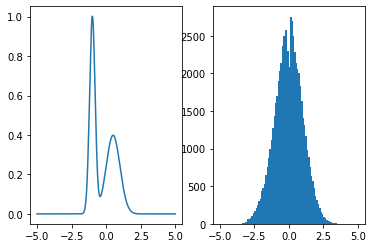

In [46]:
fig, axes = plt.subplots(1, 2, sharex=True)
xs = np.linspace(-5, 5, 64 * 500)
axes[0].plot(xs, data_pdf(xs))
result = []

for i in range(1000):
    temp = sample_data(64)
    z, _ = model(temp)
    result.append(z)

z = np.concatenate(result)
#axes[1].plot(xs, z)
axes[1].hist(z, bins=100, range=[-5, 5])